<a href="https://colab.research.google.com/github/BenYavor/MA_GAN/blob/master/Changed_MA_GAN_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.0.0
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt   
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    import tensorflow as tf
import os
tf.__version__
from tensorflow import keras
import time
from __future__ import absolute_import, division, print_function, unicode_literals
import pandas as pd


###Systemparameter
ACHTUNG: CHANNELANZAHL WURDE UNTERSCHIEDLICH VERWENDET \\
$k$ - die Anzhal der bits \\
$M$ - Anzahl der unterschiedlichen Nachrichten \\
$n$ - channel uses\\
$N$ - Länge des Rauschvektors

In [0]:
k = 4      # Number of information bits per message, i.e., M=2**k
M = 2**k
n = 2    # Number of real channel uses per message
#k = int(np.log2(M))
#n = 2
TRAINING_SNR = 7

batch_size = 100

x = tf.random.normal((batch_size,n))    #randomly sample input data ("fake" AE messages)
x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x))) #Average power normalization (not required if standard normal distribution is used )


## Generator Model

In [0]:
def EbNo2Sigma(ebnodb):
    '''Convert Eb/No in dB to noise standard deviation'''
    ebno = 10**(ebnodb/10)
    return 1/np.sqrt(2*(2*k/n)*ebno)

  
train_SNR_dB = 7
noise_std = EbNo2Sigma(train_SNR_dB)

# Generator model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
tf_op_layer_Shape (TensorFlowOp [(2,)]               0           input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [()]                 0           tf_op_layer_Shape[0][0]          
__________________________________________________________________________________________________
tf_op_layer_random_normal/shape [(2,)]               0           tf_op_layer_strided_slice[0][0]  
______________________________________________________________________________________________

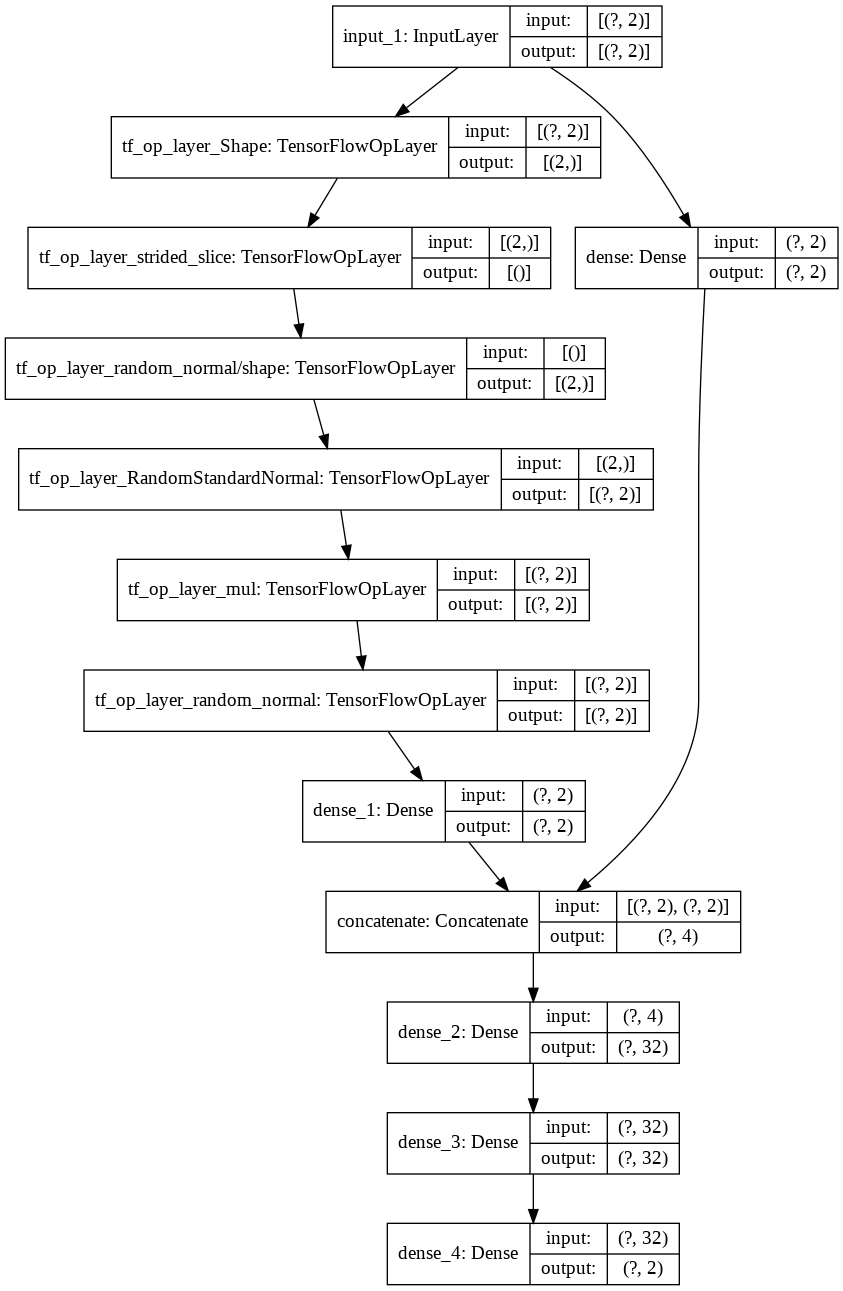

In [4]:
input1 = tf.keras.layers.Input(shape=(n,))
x1 = tf.keras.layers.Dense(n)(input1)
input2 =tf.random.normal([tf.shape(input1)[0],n])
x2 = tf.keras.layers.Dense(n)(input2)
subtracted = tf.keras.layers.Concatenate(1)([x1, x2])
h1 = tf.keras.layers.Dense(32,use_bias=True,  activation='relu')(subtracted)
h2 = tf.keras.layers.Dense(32,use_bias=True, activation='relu')(h1)
out = tf.keras.layers.Dense(n, use_bias= True, activation='linear')(h2)

generator = tf.keras.models.Model(inputs=[input1], outputs=out)
generator.summary()

tf.print(generator([x]).shape)


keras.utils.plot_model(generator, 'Structure_of_MI_estimation.png', show_shapes=True)

## Channels as Black-Box

In [0]:


def real_channel(x):
    # Black-box Channel
    #AWGN
    return x + tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std)

    #Rayleigh
    #return x + tf.sqrt(tf.square(tf.random_normal(tf.shape(x), mean=0.0, stddev=noise_std)) + tf.square(tf.random_normal(tf.shape(x), mean=0.0, stddev=noise_std)))
    
    #Uniform U(-3;3)    
    #return x + tf.random_uniform(tf.shape(x), minval=-2, maxval=2)

    


In [0]:


def analytic_channel(input): 
  #print(input.shape)
  return input + tf.random.normal(tf.shape(input), mean=0.0, stddev=noise_std)

def real_transmision(test_data):
  y = encoder(test_data)
  y = generator(y)
  y = decoder(y)
  return y


def test_diff_eval(test_data, results):
  diff = []
  for i in range(tf.shape(test_data)[0]):
    diff.append(tf.math.subtract(test_data[i], results[i]))
  return diff
    
  
#real_AE = real_transmision(test_data)
#testTest = tf.dtypes.cast(real_AE + tf.constant(0.2,dtype=tf.float32,shape=tf.shape(real_AE)), tf.int32)

#diff_test =  test_diff_eval(test_data, real_AE) 





## Discriminator
Model definition and creating discriminator


In [0]:
randN_initial = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)


In [8]:
def get_discriminator():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(32,use_bias=True, kernel_initializer=randN_initial,activation='relu',input_shape=((2*n,))))
  #model.add(tf.keras.layers.Dense(32,use_bias=True, kernel_initializer=randN_initial, activation='relu'))
  model.add(tf.keras.layers.Dense(1,use_bias=False, activation='sigmoid'))
  return model

discriminator = get_discriminator()
discriminator.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 32)                160       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 32        
Total params: 192
Trainable params: 192
Non-trainable params: 0
_________________________________________________________________


## Data Generation, überhaupt noch relevant??!!

## discriminator desicion????


In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## defining Loss. TODO:
compile the Model with the right loss functions

In [10]:
x = tf.random.normal((batch_size,n),dtype=tf.dtypes.float32)    #randomly sample input data ("fake" AE messages)
x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x)))
real_training_data = tf.concat(values=[real_channel(x), x], axis=-1)  
fake_training_data = tf.concat(values=[generator([x]),x], axis=-1)# training =True),x], axis=-1)

tf.print(real_training_data.shape,fake_training_data.shape)
real_output = discriminator(real_training_data)
fake_output = discriminator(fake_training_data)
tf.print(fake_output)
tf.print(real_output)
#print(real_output, fake_output)

TensorShape([100, 4]) TensorShape([100, 4])
[[0.52037406]
 [0.504116595]
 [0.508760512]
 ...
 [0.501697]
 [0.501199663]
 [0.506782353]]
[[0.548480213]
 [0.506040037]
 [0.518192947]
 ...
 [0.50282234]
 [0.502090037]
 [0.509592116]]


In [0]:
#def discriminator_loss(real_output, fake_output):
  #loss= -tf.reduce_mean(tf.math.log(real_output) + tf.math.log(1. - fake_output))   #use "-" sign to minimize rather than maximize loss
#  loss = tf.reduce_mean(real_output) - tf.reduce_mean(fake_output)  #Wasserstein GAN
#  return loss

def generator_loss(fake_output, generator):
  return -tf.reduce_mean(fake_output)


# Learning Rate

In [0]:
generator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)      #RMSprop   in oreder to test where the error comes from
discriminator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)      #

# Evaluation with Histogram

In [0]:
def B_Ber(input_msg, msg):
    '''Calculate the Batch Bit Error Rate'''
    pred_error = tf.not_equal(tf.argmax(msg, 1), tf.argmax(input_msg, 1))
    bber = tf.reduce_mean(tf.cast(pred_error, tf.float32))
    return bber

def random_sample(batch_size=32):
    msg = np.random.randint(M, size=batch_size)
    return msg

TRAINING_SNR = 7

In [0]:
def generate_evaluation_data(batch_size=100):
  x = tf.random.normal((batch_size,n),dtype=tf.dtypes.float32)    #randomly sample input data ("fake" AE messages)
  x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x))) #Average power normalization (not required if standard normal distribution is used )
  #G_n = tf.random.normal([tf.shape(x)[0],n],dtype=tf.float32) 
  #inputs = tf.concat(values=[x, G_n], axis=1)
  fake_eval_data = tf.concat(values=[generator([x]), x], axis=1)
  real_eval_data = tf.concat(values=[real_channel(x), x], axis=1) #tf.concat(values=[real_channel(x),x], axis=1)
  inputs = x
  return  real_eval_data, fake_eval_data, inputs 



def get_evaluation_data(evaluation_per_epochs):
  real_eval_data = []
  fake_eval_data  = []
  inputs = []
  for i in range(evaluation_per_epochs):
    data = generate_evaluation_data()
    real_eval_data.append(data[0])
    fake_eval_data.append(data[1])
    inputs.append(data[2])
  return real_eval_data, fake_eval_data, inputs


def test_eval(real_eval_data,fake_eval_data,inputs):
  hist_range = 3
  

  
  fake_output_hist = np.mean(fake_eval_data,axis=0)  # Changed from 0 to 1
  real_output_hist = np.mean(real_eval_data,axis=0)
  inputs_hist = np.mean(inputs,axis=0)
    
  fake_output_hist1 = np.reshape( fake_output_hist,[-1,])
  real_output_hist1 = np.reshape( real_output_hist,[-1,])
    
  plt.hist(fake_output_hist1,bins=100,range=(-hist_range,hist_range),density=True,histtype='step')
  plt.hist(real_output_hist1,bins=100,range=(-hist_range,hist_range),density=True,histtype='step')    
  plt.title("noise distribution")
  plt.legend(["generator", "target"])
  plt.show()
  tf.print(inputs_hist.shape)
  
  

In [0]:
def EbNo_to_noise(ebnodb):
    '''Transform EbNo[dB]/snr to noise power'''
    ebno = 10**(ebnodb/10)
    noise_std = 1/np.sqrt(2*(k/n)*ebno) 
    return noise_std

def SNR_to_noise(snrdb):
    '''Transform EbNo[dB]/snr to noise power'''
    snr = 10**(snrdb/10)
    noise_std = 1/np.sqrt(2*snr)
    return noise_std

In [0]:
def random_sample(batch_size=32):
    msg = np.random.randint(M, size=batch_size)
    return msg

### Define the training loop

In [0]:
epochs = 2000
batch_size = 100

evaluation_per_epochs = 10

seed = tf.random.normal([batch_size, n])



In [0]:
def train(epochs, batch_size):
  start = time.time()
  counter = 0
  epoch = 0
  for epoch in range(epochs):
    counter += 1
    train_step()
    if counter%100==0:
      tf.print("counter %d:" % (counter))
      fake_c = generator(x)
      tf.print(fake_c[0])
    if counter%1000 == 0:
      real_c = real_channel(x)
      fake_c = generator(x)
      real_eval_data, fake_eval_data, inputs = get_evaluation_data(evaluation_per_epochs)
      test_eval(real_eval_data, fake_eval_data, inputs)
      #tf.print(disc_loss, gen_loss)
    #print ('Time for epoch {} is {} sec,'.format(epoch + 1, time.time()-start))
      tf.print ('Time for epoch {},'.format(epoch + 1))
      
  tf.saved_model.save(generator,'/tmp/saved_model/')
  tf.print ('Time for the training is {} sec,'.format( time.time()-start))
    

## Training
strongly inspiered by: \\
https://www.tensorflow.org/beta/tutorials/generative/dcgan?hl=en

In [0]:
@tf.function
def train_step(): #epoch, steps_per_epoches , batch_size, generator, discriminator):
  x = tf.random.normal((batch_size,n),dtype=tf.dtypes.float32)    #randomly sample input data ("fake" AE messages)
  x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x)))
  m = random_sample(batch_size)
  r = encoder(m)
  for i in range(5):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      real_training_data = tf.concat(values=[real_channel(r), x], axis=1)
      fake_training_data = tf.concat(values=[generator(r),x], axis=1)# training =True),x], axis=1)
      real_output = discriminator(real_training_data)#, training=True)
      fake_output = discriminator(fake_training_data)
      
      
      disc_loss = -tf.reduce_mean(tf.math.log(real_output) + tf.math.log(1. - fake_output))
      gen_loss =-tf.reduce_mean(tf.math.log(fake_output))
      
      #tf.print(disc_loss,gen_loss)
      
      if tf.math.is_nan(disc_loss) == False:
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
      if i == 4:  
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))



## Train the model

In [20]:
EncIn = tf.keras.layers.Input(shape=(M,))#, dtype= tf.int32)
e1 = tf.keras.layers.Dense(n, activation=None)
e2 = tf.keras.layers.Lambda(lambda x:tf.reshape(x, shape=[-1,int(n/2),2]))
EncOut = tf.keras.layers.Lambda(lambda x: x/tf.sqrt(2*tf.reduce_mean(tf.square(x))))
GenIn = tf.keras.layers.Lambda(lambda x:tf.reshape(x,(tf.shape(x)[0],-1)))
GenOut = tf.keras.layers.Lambda(generator)
DecIn = tf.keras.layers.Lambda(lambda x:tf.reshape(x, shape=[-1,int(n/2),2]))
d1 = tf.keras.layers.Lambda(lambda x:tf.reshape(x, shape=[-1,n]))
d2 = tf.keras.layers.Dense(M, activation='relu')
DecOut = tf.keras.layers.Dense(M, activation='softmax')

noise_std = EbNo_to_noise(TRAINING_SNR)
# custom functions / layers without weights
norm_layer = keras.layers.Lambda(lambda x: tf.divide(x,tf.sqrt(2*tf.reduce_mean(tf.square(x)))))
shape_layer = keras.layers.Lambda(lambda x: tf.reshape(x, shape=[-1,2,n]))
shape_layer2 = keras.layers.Lambda(lambda x: tf.reshape(x, shape=[-1,2*n]))
channel_layer = keras.layers.Lambda(lambda x: 
                    x + tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std))

encoder = keras.models.Sequential([
            keras.layers.Embedding(M, M, embeddings_initializer='glorot_normal'),
            keras.layers.Dense(M, activation="elu"),
            keras.layers.Dense(n, activation=None),
            e2,
            EncOut,
            GenIn])



channel = keras.layers.Lambda(lambda x: 
                    x + tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std))


#channel.summary()

decoder = keras.models.Sequential([
                #keras.layers.InputLayer(input_shape=[2,n]),
                #shape_layer2,
                DecIn,
                d1,
                keras.layers.Dense(M, activation="elu"),
                keras.layers.Dense(M, activation="softmax")
                ])


data, test_data = random_sample(10000000), random_sample(10000)

####Training only the transmitter
AE = keras.models.Sequential([encoder,channel,decoder])
encoder.trainable =False
AE.compile(optimizer='nadam',loss='sparse_categorical_crossentropy',metrics=[B_Ber])
history = AE.fit(data, data, batch_size=500,steps_per_epoch=300, epochs=10)

######Training only the encoder
gen_AE = keras.models.Sequential([encoder,generator,decoder])
encoder.trainable =True
decoder.trainable = False
generator.trainable = False
AE.compile(optimizer='nadam',loss='sparse_categorical_crossentropy',metrics=[B_Ber])
history = AE.fit(data, data, batch_size=500,steps_per_epoch=300, epochs=10)



Train on 10000000 samples
Epoch 1/10
  143000/10000000 [..............................] - ETA: 35s - loss: 0.9496 - B_Ber: 0.9376Train on 10000000 samples
Epoch 1/10
  144500/10000000 [..............................] - ETA: 38s - loss: 0.7963 - B_Ber: 0.9312

counter 100:
[0.172628731 0.902830899]
counter 200:
[0.908023596 0.230608299]
counter 300:
[0.113770321 1.65728068]
counter 400:
[0.769403279 -0.634021]
counter 500:
[0.657041907 0.824717045]
counter 600:
[0.85471344 0.502246141]
counter 700:
[0.644155264 0.593010306]
counter 800:
[2.39703131 -1.0667181]
counter 900:
[1.06166446 1.68319714]
counter 1000:
[0.244277418 2.19582748]


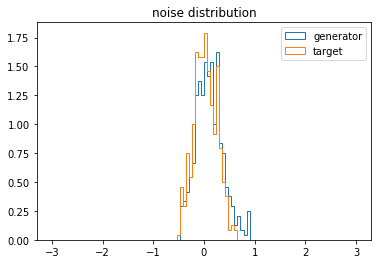

(100, 2)
Time for epoch 1000,
counter 1100:
[0.942913651 -0.404169381]
counter 1200:
[-0.265572965 1.58346784]
counter 1300:
[-0.0445319116 0.777244]
counter 1400:
[0.318450212 -0.643608]
counter 1500:
[-0.282914847 0.960686743]
counter 1600:
[1.34015656 -0.514339924]
counter 1700:
[-1.51299906 1.01236975]
counter 1800:
[-0.856015 0.933549762]
counter 1900:
[0.244337514 -0.296252966]
counter 2000:
[-0.0165641103 0.0974783748]


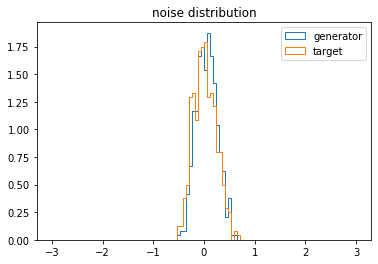

(100, 2)
Time for epoch 2000,
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /tmp/saved_model/assets
Time for the training is 8.316393852233887 sec,
CPU times: user 11.1 s, sys: 866 ms, total: 12 s
Wall time: 8.32 s


In [21]:
%%time
generator.trainable = True
encoder.trainable = True
train(epochs , batch_size)


### Setting Generator as not trainable before training AE

In [22]:
######Training only the encoder
gen_AE = keras.models.Sequential([encoder,generator,decoder])
encoder.trainable =True
decoder.trainable = False
generator.trainable = False
AE.compile(optimizer='nadam',loss='sparse_categorical_crossentropy',metrics=[B_Ber])
history = AE.fit(data, data, batch_size=500,steps_per_epoch=300, epochs=10)

Train on 10000000 samples
Epoch 1/10
  144000/10000000 [..............................] - ETA: 38s - loss: 0.7973 - B_Ber: 0.9333

## AE
Die Idee sollte sein das Training auf den encoder und decoder einzuschränken. Jedoch soll **end-to-end** trainiert werden, hierfür sollte vllt eine art Funktion eingesetzt werden, welche über die GAN's Layer zurück geht.
Muss ich hierfür die Layer nochmals einzeln definieren?


***Vermutung: Der Ausgang hat die 8fache dimension des Eingangs-> daher nur 1/8 richtig oder 7/8 richtig*** \\
**zu klären: was passiert in meinem AE dass sie dei dimension ver8-facht von (1000,8) zu (8000,n)**
**Kontrollieren was der output von meinem GAN ist**
**Add complexity for higher rubustness**




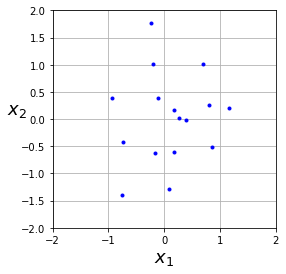

In [23]:
def test_encoding(M=16, n=1):
    inp = np.arange(0,M)
    coding = encoder.predict(inp)
    fig = plt.figure(figsize=(4,4))
    plt.plot(coding[:,0], coding[:, 1], "b.")
    plt.xlabel("$x_1$", fontsize=18)
    plt.ylabel("$x_2$", fontsize=18, rotation=0)
    plt.grid(True)
    plt.gca().set_ylim(-2, 2)
    plt.gca().set_xlim(-2, 2)
    plt.show()

test_encoding(M,n)   

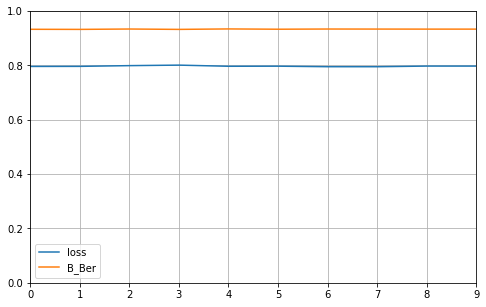

In [24]:
pd.DataFrame(history.history).plot(figsize=(8, 5)) 
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()